In [1]:
import keras
from keras import backend as K
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, ELU, Permute, TimeDistributed
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, MaxPool2D
from keras.layers import Input, LSTM, RepeatVector, Lambda,Bidirectional,CuDNNLSTM
from keras import regularizers
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import objectives
import numpy as np
import matplotlib.pyplot as plt
import time
from keras.regularizers import l2
from keras import layers, models
from keras.regularizers import L1L2

Using TensorFlow backend.


In [2]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [3]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [4]:
y_train_valid -= 769
y_test = y_test-769

In [5]:
# def rnn(input_shape):
#     model = Sequential()
#     model.add(Bidirectional(LSTM(128, recurrent_dropout=0.25, return_sequences=True,input_shape=input_shape, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))    
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))
#     model.add(Bidirectional(LSTM(64, recurrent_dropout=0.25, return_sequences=True,input_shape=input_shape, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))    
#     model.add(BatchNormalization())
#     model.add(Flatten())
#     model.add(Dropout(0.5))    
#     model.add(Dense(32,activation='elu'))
#     model.add(Dropout(0.5))    
#     model.add(Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.02)))    
#     opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
#     model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['acc'])
#     return model

In [6]:
def crnn(input_shape):
    model = Sequential()

    model.add(Conv2D(40, kernel_size=(1, 40), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01), input_shape=input_shape, data_format='channels_last'))
    model.add(ELU())
    model.add(BatchNormalization())

    model.add(Conv2D(40, kernel_size=(22, 1), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization())
    model.add(MaxPool2D((1, 4)))
    model.add(Dropout(0.4))
    
    model.add(Permute((2, 3, 1)))
    model.add(TimeDistributed(Flatten()))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(32)))#reduce dims from 3 to 2// could use Flatten() instead
    model.add(Dropout(0.4))
    model.add(Dense(4, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='softmax'))
    opt = keras.optimizers.Adam(lr=0.005, epsilon=1e-8, decay=0.01)
    model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['acc'])
    
    return model

In [7]:
def train(model, x_train, y_train, x_test, y_test):
    history = model.fit(x_train,y_train,batch_size=50,epochs=200,shuffle=True,validation_split = 0.2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return model

In [8]:
def predict(model,x_test,y_test):
    y_pred = model.predict(x_test)
    accuracy = 0
    for i in range(y_pred.shape[0]):
        if np.argmax(y_test[i]) == np.argmax(y_pred[i]):
            accuracy += 1
    accuracy /= x_test.shape[0]
    return accuracy

In [9]:
window_length = 10
hop_length = 5
n_windows =(1000-window_length) // hop_length + 1 

In [10]:
def reshape(data): #by default data's dimesnion is 3
    data_new = np.zeros((data.shape[0],n_windows,window_length*22)) #local variable
    for i in range(data.shape[0]):
        raw = data[i].transpose(1,0)
        for j in range(n_windows):
            data_new[i,j] = raw[j*hop_length:j*hop_length+window_length].flatten()
    return data_new


In [11]:
x_train = X_train_valid[:,:22,:].astype('float32')
x_test = X_test[:,:22,:].astype('float32')

y_train = y_train_valid
y_test = y_test

# x_train = reshape(x_train)# (2115, 199, 220)
# x_test = reshape(x_test)# (443, 199, 220)

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

Train on 1692 samples, validate on 423 samples
Epoch 1/200
1692/1692 [==============================] - 63s 37ms/step - loss: 1.6795 - acc: 0.2801 - val_loss: 1.4892 - val_acc: 0.2979
Epoch 2/200
1692/1692 [==============================] - 60s 35ms/step - loss: 1.4428 - acc: 0.3375 - val_loss: 1.4343 - val_acc: 0.3144
Epoch 3/200
1692/1692 [==============================] - 61s 36ms/step - loss: 1.4117 - acc: 0.3658 - val_loss: 1.4117 - val_acc: 0.3357
Epoch 4/200
1692/1692 [==============================] - 59s 35ms/step - loss: 1.3791 - acc: 0.3783 - val_loss: 1.4313 - val_acc: 0.3286
Epoch 5/200
1692/1692 [==============================] - 60s 35ms/step - loss: 1.3676 - acc: 0.3948 - val_loss: 1.3917 - val_acc: 0.3712
Epoch 6/200
1692/1692 [==============================] - 58s 34ms/step - loss: 1.3821 - acc: 0.3859 - val_loss: 1.4218 - val_acc: 0.3712
Epoch 7/200
1692/1692 [==============================] - 58s 34ms/step - loss: 1.3459 - acc: 0.4090 - val_loss: 1.3773 - val_acc: 0

1692/1692 [==============================] - 100s 59ms/step - loss: 0.2217 - acc: 0.9675 - val_loss: 2.0677 - val_acc: 0.4728
Epoch 61/200
1692/1692 [==============================] - 101s 60ms/step - loss: 0.2405 - acc: 0.9604 - val_loss: 2.0773 - val_acc: 0.4728
Epoch 62/200
1692/1692 [==============================] - 101s 60ms/step - loss: 0.2228 - acc: 0.9634 - val_loss: 2.1317 - val_acc: 0.4823
Epoch 63/200
1692/1692 [==============================] - 102s 60ms/step - loss: 0.2004 - acc: 0.9770 - val_loss: 2.1211 - val_acc: 0.4657
Epoch 64/200
1692/1692 [==============================] - 102s 60ms/step - loss: 0.2008 - acc: 0.9758 - val_loss: 2.1174 - val_acc: 0.4775
Epoch 65/200
1692/1692 [==============================] - 102s 60ms/step - loss: 0.2079 - acc: 0.9693 - val_loss: 2.0905 - val_acc: 0.4894
Epoch 66/200
1692/1692 [==============================] - 103s 61ms/step - loss: 0.2071 - acc: 0.9704 - val_loss: 2.1330 - val_acc: 0.4610
Epoch 67/200
1692/1692 [================

1692/1692 [==============================] - 89s 52ms/step - loss: 0.1177 - acc: 0.9947 - val_loss: 2.3160 - val_acc: 0.4752
Epoch 120/200
1692/1692 [==============================] - 89s 53ms/step - loss: 0.1218 - acc: 0.9941 - val_loss: 2.2615 - val_acc: 0.4681
Epoch 121/200
1692/1692 [==============================] - 89s 52ms/step - loss: 0.1206 - acc: 0.9941 - val_loss: 2.3468 - val_acc: 0.4586
Epoch 122/200
1692/1692 [==============================] - 89s 53ms/step - loss: 0.1253 - acc: 0.9923 - val_loss: 2.3748 - val_acc: 0.4634
Epoch 123/200
1692/1692 [==============================] - 89s 53ms/step - loss: 0.1237 - acc: 0.9941 - val_loss: 2.3320 - val_acc: 0.4586
Epoch 124/200
1692/1692 [==============================] - 95s 56ms/step - loss: 0.1139 - acc: 0.9959 - val_loss: 2.3150 - val_acc: 0.4681
Epoch 125/200
1692/1692 [==============================] - 99s 58ms/step - loss: 0.1265 - acc: 0.9911 - val_loss: 2.3454 - val_acc: 0.4681
Epoch 126/200
1692/1692 [================

1692/1692 [==============================] - 64s 38ms/step - loss: 0.0988 - acc: 0.9965 - val_loss: 2.3502 - val_acc: 0.4539
Epoch 179/200
1692/1692 [==============================] - 65s 38ms/step - loss: 0.0994 - acc: 0.9953 - val_loss: 2.3256 - val_acc: 0.4610
Epoch 180/200
1692/1692 [==============================] - 64s 38ms/step - loss: 0.0968 - acc: 0.9970 - val_loss: 2.3625 - val_acc: 0.4468
Epoch 181/200
1692/1692 [==============================] - 65s 38ms/step - loss: 0.0945 - acc: 0.9982 - val_loss: 2.3634 - val_acc: 0.4610
Epoch 182/200
1692/1692 [==============================] - 64s 38ms/step - loss: 0.1007 - acc: 0.9947 - val_loss: 2.3277 - val_acc: 0.4610
Epoch 183/200
1692/1692 [==============================] - 64s 38ms/step - loss: 0.0954 - acc: 0.9965 - val_loss: 2.3067 - val_acc: 0.4586
Epoch 184/200
1692/1692 [==============================] - 64s 38ms/step - loss: 0.0911 - acc: 0.9988 - val_loss: 2.3323 - val_acc: 0.4704
Epoch 185/200
1692/1692 [================

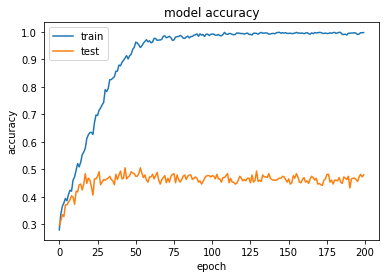

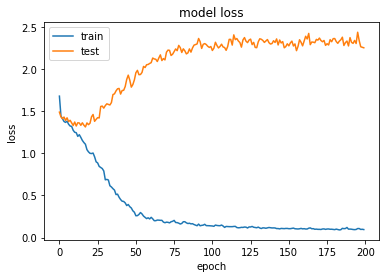

0.5079006772009029
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 961, 40)       1640      
_________________________________________________________________
elu_1 (ELU)                  (None, 22, 961, 40)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 961, 40)       160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 961, 40)        35240     
_________________________________________________________________
elu_2 (ELU)                  (None, 1, 961, 40)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 961, 40)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None,

In [12]:
def CRNN(x_train,y_train,x_test,y_test):
    train_example = x_train
    test_example = x_test
    train_target = keras.utils.to_categorical(y_train, 4)
    test_target = keras.utils.to_categorical(y_test, 4)
    
    model = crnn(train_example[0].shape)
    model = train(model,train_example,train_target,test_example,test_target)
    acc = predict(model,test_example,test_target)
    print(acc)
    model.summary()
    return acc

acc = CRNN(x_train,y_train,x_test,y_test)